In [244]:
# libraries to import
import sys
sys.path.append('../algorithms')  # Add the directory to the import search path
from helper_functions import *
from linear_bandits_algorithms import *
from utils import *

In [245]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(50) # 2 is good for isomap but not for pca # 0 is good for later stages


class LinUCB:
    def __init__(self, n_arms, n_features, item_features, n_rounds, lambda_param, beta_fixed=True, beta_value=1.0):
        self.n_arms = n_arms
        self.n_features = n_features
        self.item_features = item_features
        self.n_rounds = n_rounds
        self.lambda_param = lambda_param
        self.beta_fixed = beta_fixed
        self.beta_value = beta_value

        # Initializing variables
        self.V_t = lambda_param * np.eye(n_features)
        self.sum_A_s_X_s = np.zeros(n_features)
        self.theta_hat = np.zeros((n_features, n_rounds + 1))
        self.theta_hat[:, 0] = np.random.uniform(low=-1, high=1, size=(n_features, 1)).reshape((n_features,))

        self.beta_param_t = beta_value
        self.actions = np.zeros(n_rounds + 1, dtype=int)
        self.rewards = np.zeros(n_rounds + 1)

    # Choose the best action based on the last theta_hat
    def choose_action(self, curr_round):
        if(self.beta_fixed==False):
            # must increase logarithmically
            self.beta_param_t = np.log(curr_round + 1.0) + 1.0

        max_value = -np.Inf
        max_index = -1
        for i in range(self.n_arms):
            # Compute the UCB for each arm using the given formula
            estimated_value = self.theta_hat[:, curr_round - 1].T @ self.item_features[:, i]
            penalty_value = np.sqrt(self.beta_param_t) * np.sqrt(
                self.item_features[:, i].T @ (np.linalg.inv(self.V_t) @ self.item_features[:, i]))
            value = estimated_value + penalty_value
            if value >= max_value:
                max_value = value
                max_index = i

        # Storing it
        self.actions[curr_round] = max_index
        return max_index

    # Updating variables after receiving the reward from an action
    def update(self, curr_round, reward):
        self.rewards[curr_round] = reward

        # Update the feature matrix V_t by adding the outer product of the chosen action's feature vector with itself.
        self.V_t += np.outer(self.item_features[:, self.actions[curr_round]],
                             self.item_features[:, self.actions[curr_round]])

        # Compute the inverse of the updated feature matrix V_t.
        V_t_inv = np.linalg.inv(self.V_t)

        # Update the label vector sum_A_s_X_s by adding the outer product of the chosen action's feature vector with the observed reward.
        self.sum_A_s_X_s += self.item_features[:, self.actions[curr_round]] * self.rewards[curr_round]

        # Compute the new estimate of the true_theta vector using the updated feature matrix and label vector.
        # This estimate represents the center of the ellipsoid in the feature space.
        self.theta_hat[:, curr_round] = V_t_inv @ self.sum_A_s_X_s

    # Returns the matrix of each estimated theta at every round
    def get_all_theta_hat(self):
        return self.theta_hat
    
    # Returns the last estimated theta
    def get_last_theta_hat(self):
        return self.theta_hat[:, self.n_rounds]
    
    # Returns the V_t matrix
    def get_last_v_t(self):
        return self.V_t



class EnvironmentLinUCB:
    def __init__(self, n_arms, n_features, item_features, n_rounds, noise, max_reward, item_rewards):
        self.n_arms = n_arms
        self.n_features = n_features
        self.item_features = item_features
        self.n_rounds = n_rounds
        self.noise = noise
        self.item_rewards = item_rewards

        # Initializing variables
        self.optimal_reward = max_reward 
        self.rewards = np.zeros(n_rounds + 1)  # rewards with noise
        self.regrets = np.zeros(n_rounds + 1)

    # Observe the reward of the chosen action and add noise
    def observe_reward(self, curr_round, action):
        expected_reward = self.item_rewards[action]
        self.rewards[curr_round] = expected_reward + np.random.normal(
            scale=self.noise)  
        return expected_reward, self.rewards[curr_round]

    # Compute the regret for this round
    def calculate_regret(self, curr_round, expected_reward):
        regret = self.optimal_reward - expected_reward
        self.regrets[curr_round] = self.regrets[curr_round - 1] + regret

    # Returns the cumulative regret
    def get_regrets(self):
        return self.regrets

# Run a simulation of linear UCB
def run_lin_ucb(n_arms, n_features, item_features, n_rounds, max_reward, item_rewards, noise, lambda_param, beta_fixed=True, beta_value=1.0):
    # Initializing the LinUCB class
    linucb = LinUCB(n_arms, n_features, item_features, n_rounds, lambda_param, beta_fixed, beta_value)

    # Initializing the environment
    environment = EnvironmentLinUCB(n_arms, n_features, item_features, n_rounds, noise, max_reward, item_rewards)

    for t in range(1, n_rounds + 1):
        # Picking up the best action based on theta_hat
        arm_chosen = linucb.choose_action(t)

        # Reward received based on the action taken
        expected_reward, reward_with_noise = environment.observe_reward(t, arm_chosen)

        # Compute regret
        environment.calculate_regret(t, expected_reward)

        # Update algorithm values after receiving reward
        linucb.update(t, reward_with_noise)

    regrets = environment.get_regrets()
    all_theta_hat = linucb.get_all_theta_hat()
    last_theta_hat = linucb.get_last_theta_hat()
    last_v_t = linucb.get_last_v_t()


    return regrets, all_theta_hat, last_theta_hat, last_v_t


def run_lin_ucb_average(n_simulations, n_arms, n_features, n_rounds, max_reward, item_rewards, item_features, noise, lambda_param, beta_fixed=True, beta_value=1.0):
    total_regrets = np.zeros(n_rounds + 1)
    total_all_theta_hat = np.zeros((n_features, n_rounds + 1))
    total_last_theta_hat = np.zeros(n_features)
    total_last_v_t = np.eye(n_features)

    for i in range(n_simulations):
        # Generating new values of true theta and item features
        curr_regret_array, curr_all_theta_hat, curr_last_theta_hat, curr_last_v_t = run_lin_ucb(n_arms, n_features, item_features, n_rounds, max_reward, item_rewards, noise, lambda_param, beta_fixed, beta_value)
        total_regrets += curr_regret_array
        total_all_theta_hat += curr_all_theta_hat
        total_last_theta_hat += curr_last_theta_hat
        total_last_v_t += curr_last_v_t

    avg_regret = total_regrets / n_simulations
    avg_curr_all_theta_hat = total_all_theta_hat / n_simulations
    avg_last_theta_hat = total_last_theta_hat / n_simulations
    avg_last_v_t = total_last_v_t / n_simulations

    return avg_regret, avg_curr_all_theta_hat, avg_last_theta_hat, avg_last_v_t


def plot_regret(regrets, title):
    # Plot the results
    plt.plot(regrets)
    plt.xlabel('Round')
    plt.ylabel('Cumulative Regret')
    if(len(title) > 0):
        plt.title(title)
    plt.show()

def plot_multiple(list_of_plots, list_of_labels, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    for i, plot in enumerate(list_of_plots):
        ax.plot(plot, label=list_of_labels[i])

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.grid()
    ax.legend()
    plt.show()

def diff_theta_hat_true_theta(true_theta, theta_hat_array):
    n_features = theta_hat_array.shape[0]
    n_rounds = theta_hat_array.shape[1]
    diff_per_round = np.zeros(n_rounds)

    for i in range(n_rounds):
        diff = np.abs(np.subtract(true_theta, theta_hat_array[:, i].reshape(n_features, 1)))
        total_diff = np.sum(diff)
        diff_per_round[i] = total_diff

    return diff_per_round

def plot_diff_theta_hat_true_theta(diff_per_round):
    # Plot the results
    plt.plot(diff_per_round)
    plt.xlabel('Round')
    plt.ylabel('Absolute difference between true theta and estimated theta')
    plt.show()
    

def plot_multiple_diff_theta_hat_true_theta(list_of_diff_per_round, list_of_labels):
    fig, ax = plt.subplots()
    for i, cumulative_regrets in enumerate(list_of_diff_per_round):
        ax.plot(cumulative_regrets, label=list_of_labels[i])

    ax.set(xlabel='Time steps', ylabel='Absolute difference', title='Absolute difference between true theta and estimated theta')
    ax.grid()
    ax.legend()
    plt.show()


# For testing purposes
def lin_ucb_choose_action_test(curr_round, theta_hat, V_t, n_arms, item_features, beta_fixed=True, beta_value=1.0):
    beta_param_t = beta_value
    if(beta_fixed==False):
        # must increase logarithmically
        beta_param_t = np.log(curr_round + 1.0) + 1.0

    indices_values = []
    max_value = -np.Inf
    max_index = -1
    for i in range(n_arms):
        # Compute the UCB for each arm using the given formula
        estimated_value = theta_hat.T @ item_features[:, i]
        penalty_value = np.sqrt(beta_param_t) * np.sqrt(
            item_features[:, i].T @ (np.linalg.inv(V_t) @ item_features[:, i]))
        value = estimated_value + penalty_value
        indices_values.append((i, value))
        if value >= max_value:
            max_value = value
            max_index = i

    return max_index, max_value, indices_values

def separate_training_test_data(ratings_by_reviewer, test_portion):
    ratings_by_reviewer_training = {}
    ratings_by_reviewer_test = {}
    
    for reviewer in ratings_by_reviewer:
        music_reviewed_ids = list(ratings_by_reviewer[reviewer].keys())
        np.random.shuffle(music_reviewed_ids)  # Shuffle the list of music reviewed IDs
        
        split_index = int(len(music_reviewed_ids) * (1 - test_portion))
        training_ids = music_reviewed_ids[:split_index]
        test_ids = music_reviewed_ids[split_index:]
        
        ratings_by_reviewer_training[reviewer] = {music_id: ratings_by_reviewer[reviewer][music_id] for music_id in training_ids}
        ratings_by_reviewer_test[reviewer] = {music_id: ratings_by_reviewer[reviewer][music_id] for music_id in test_ids}
    
    return ratings_by_reviewer_training, ratings_by_reviewer_test

def get_item_features_and_rewards_for_user(n_features, ratings_for_selected_user, features_by_musics_dict):
  n_arms = len(ratings_for_selected_user.keys())
  item_features = np.zeros((n_features, n_arms))
  item_rewards = np.zeros(n_arms)
  items_order = []

  index = 0
  for music_id in ratings_for_selected_user:
    feature_vector = features_by_musics_dict[music_id]
    item_features[:,index] = feature_vector
    item_rewards[index] = ratings_for_selected_user[music_id]
    items_order.append(music_id)
    index += 1

  return item_features, item_rewards, items_order

def train_linear_ucb_for_one_user(features_by_music_id_dict, ratings_by_reviewer, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=1.0):

    n_arms = len(ratings_by_reviewer[selected_reviewer_id].keys())
    n_features = len(features_by_music_id_dict[list(features_by_music_id_dict.keys())[0]])
    item_features, item_rewards, _ = get_item_features_and_rewards_for_user(n_features, ratings_by_reviewer[selected_reviewer_id], features_by_music_id_dict)

    avg_regret, avg_all_theta_hat, avg_last_theta, avg_last_v_t = run_lin_ucb_average(n_simulations, n_arms, n_features, n_rounds, max_reward, item_rewards, item_features, noise, lambda_param, beta_fixed, beta_value)
    return (avg_regret, avg_all_theta_hat, avg_last_theta, avg_last_v_t)

def train_linear_ucb_for_one_user_all_dimensions(features_dict_by_dim, ratings_by_reviewer, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=1.0):
    results_by_dimension = {}

    # Running the algorithm for all dimensions
    for key in features_dict_by_dim:
        # Getting the dictionary with music id as key and np array of features as value
        features_by_music_id = features_dict_by_dim[key]
        results_by_dimension[key] = train_linear_ucb_for_one_user(features_by_music_id, ratings_by_reviewer, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta_value)
    return results_by_dimension

def test_ucb_linear_bandit_for_one_user(training_results, features_by_music_id_dict, ratings_by_reviewer, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=1.0):

    n_arms = len(ratings_by_reviewer[selected_reviewer_id].keys())
    n_features = len(features_by_music_id_dict[list(features_by_music_id_dict.keys())[0]])
    item_features, item_rewards, items_order = get_item_features_and_rewards_for_user(n_features, ratings_by_reviewer[selected_reviewer_id], features_by_music_id_dict)

    # Getting the V_t and the last theta hat
    last_theta_hat = training_results[2]
    last_v_t = training_results[3]
    max_index, max_value, indices_values = lin_ucb_choose_action_test(n_rounds+1, last_theta_hat, last_v_t, n_arms, item_features, beta_fixed, beta_value)

    # Returning necessary values for test results plots
    list_true_estimated = []
    absolute_diff = 0
    for tuple in indices_values:
        index = tuple[0]
        value = tuple[1]
        true_reward = ratings_by_reviewer[selected_reviewer_id][items_order[index]]
        absolute_diff += abs(float(true_reward) - float(value))
        list_true_estimated.append((float(true_reward), value))

    # First element is the average of all differences of all the test samples for that particular user (because nb of test samples varies between users)
    total_test_samples = len(indices_values)
    return (absolute_diff / float(total_test_samples), list_true_estimated, total_test_samples)


def test_ucb_linear_bandit_for_one_user_all_dimensions(training_results_by_dim, features_dict_by_dim, ratings_by_reviewer, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=1.0):
    absolute_diff_by_dim = {}

    # Running the algorithm for all dimensions
    for key in features_dict_by_dim:
        # Getting the dictionary with music id as key and np array of features as value
        features_by_music_id = features_dict_by_dim[key]
        absolute_diff_by_dim[key] = test_ucb_linear_bandit_for_one_user(training_results_by_dim[key], features_by_music_id, ratings_by_reviewer, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta_value)

    return absolute_diff_by_dim

def simulation_on_one_user(features_by_music_id_dict, ratings_by_reviewer_training, ratings_by_reviewer_test, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=1.0):

    selected_reviewer_training_results = train_linear_ucb_for_one_user(features_by_music_id_dict, ratings_by_reviewer_training, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta_value)
    selected_reviewer_absolute_diff = test_ucb_linear_bandit_for_one_user(selected_reviewer_training_results, features_by_music_id_dict, ratings_by_reviewer_test, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta_value)

    return (selected_reviewer_training_results, selected_reviewer_absolute_diff)

def simulation_on_all_users(features_by_music_id_dict, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=1.0):

    total_regrets = 0

    # To have weighted avg because all users do not have the same nb of test ratings
    total_diff = 0. # of all users
    total_nb_ratings = 0. # of all users

    for selected_reviewer_id in ratings_by_reviewer_training:
        # Running the algorithm for a given user
        selected_reviewer_training_results, selected_reviewer_absolute_diff = simulation_on_one_user(features_by_music_id_dict, ratings_by_reviewer_training, ratings_by_reviewer_test, selected_reviewer_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta_value)

        # Results for regrets for dimenstions as list
        total_regrets += selected_reviewer_training_results[0] # todo weighted
 
        avg_diff_selected_reviewer = selected_reviewer_absolute_diff[0]
        total_nb_test_reviews_of_selected_reviewer = selected_reviewer_absolute_diff[2]

        total_diff += avg_diff_selected_reviewer * total_nb_test_reviews_of_selected_reviewer
        total_nb_ratings += total_nb_test_reviews_of_selected_reviewer

    # Getting the regret averages (to analyse training)
    avg_regrets = total_regrets / len(list(ratings_by_reviewer_training.keys())) # todo weighted

    # Getting the average diff per dimensions (to analyse testing)
    avg_diff = total_diff / total_nb_ratings

    return (avg_regrets, avg_diff)

# To plot regrets after the training
def simulation_on_all_users_for_different_betas(features_by_music_id_dict, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta_values):

    avg_regrets_list = []
    avg_diff_list = []

    for beta in beta_values:
        avg_regrets, avg_diff = simulation_on_all_users(features_by_music_id_dict, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta)
        
        avg_regrets_list.append(avg_regrets)
        avg_diff_list.append(avg_diff)

    return avg_regrets_list, avg_diff_list

def simulation_on_all_users_all_dimensions(features_dict_by_dim, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta_values):

    # To store for each value of beta
    avg_regrets_by_dim_list = []
    avg_diff_by_dim_list = []

    for beta in beta_values:
        avg_regrets_by_dim = {}
        avg_diff_by_dim = {}

        for key in features_dict_by_dim:
            # for music
            features_by_music_id_dict = features_dict_by_dim[key]
            avg_regrets, avg_diff = simulation_on_all_users(features_by_music_id_dict, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed, beta)

            # Storing the results
            avg_regrets_by_dim[key] = avg_regrets
            avg_diff_by_dim[key] = avg_diff

        avg_regrets_by_dim_list.append(avg_regrets_by_dim)
        avg_diff_by_dim_list.append(avg_diff_by_dim)

    return avg_regrets_by_dim_list, avg_diff_by_dim_list

def plot_multiple_lines(list_of_lines, list_of_labels, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    for i, cumulative_regrets in enumerate(list_of_lines):
        ax.plot(cumulative_regrets, label=list_of_labels[i])

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.grid()
    ax.legend()
    plt.show()

def list_of_labels_from_values_list(list_of_values, prepend_text):
    """
    Generates a list of labels by appending a text prefix to each value in the given list.

    Args:
        list_of_values (list): The list of values.
        prepend_text (str): The text to be prepended to each value.

    Returns:
        list: A list of labels with the text prefix.
    """
    list_of_labels = []

    # Iterate over each value in the list
    for value in list_of_values:
        # Append the text prefix to the value and create the label
        label = prepend_text + str(value)

        # Add the label to the list
        list_of_labels.append(label)

    return list_of_labels




# Music recommendations and linear UCB

## Importing the users and their respecting reviews

In [246]:
ratings_by_reviewer_path = '../data/ratings_by_reviewer.csv'
ratings_by_reviewer = read_csv_as_dict_of_dict(ratings_by_reviewer_path)


Total number of reviewers with more than 50 reviews and 1.0 variance : 16

## Importing the feature vectors for the musics

In [247]:
# Dictionary containing all paths to the csv
ISOMAP_PATHS_BY_DIMENSION = {
    2: '../dimension_reduction/reduced_data_ISOMAP_2D.csv',
    3: '../dimension_reduction/reduced_data_ISOMAP_3D.csv',
    5: '../dimension_reduction/reduced_data_ISOMAP_5D.csv',
    10: '../dimension_reduction/reduced_data_ISOMAP_10D.csv'
}

# Dictionary containing a dictionary of dictionary
ISOMAP_BY_DIMENSION = {}

for key in ISOMAP_PATHS_BY_DIMENSION:
    reduced_data_isomap_path = ISOMAP_PATHS_BY_DIMENSION[key]
    reduced_data_isomap = read_csv_as_dict_of_arrays(reduced_data_isomap_path)
    # Storing the result in our dictionary
    ISOMAP_BY_DIMENSION[key] = reduced_data_isomap

# Dictionary containing all paths to the csv
PCA_PATHS_BY_DIMENSION = {
    2: '../dimension_reduction/reduced_data_PCA_2D.csv',
    3: '../dimension_reduction/reduced_data_PCA_3D.csv',
    5: '../dimension_reduction/reduced_data_PCA_5D.csv',
    10: '../dimension_reduction/reduced_data_PCA_10D.csv'
}

# Dictionary containing a dictionary of dictionary
PCA_BY_DIMENSION = {}

for key in PCA_PATHS_BY_DIMENSION:
    reduced_data_pca_path = PCA_PATHS_BY_DIMENSION[key]
    reduced_data_pca = read_csv_as_dict_of_arrays(reduced_data_pca_path)
    # Storing the result in our dictionary
    PCA_BY_DIMENSION[key] = reduced_data_pca


## Running linear UCB on one user

### Selecting a user

In [248]:
# selecting a user
all_user_ids = list(ratings_by_reviewer.keys())
selected_user_id = all_user_ids[0]


In [249]:
print("Selected user id : ", selected_user_id)

Selected user id :  A2EENLV6OQ3DYM


In [250]:
ratings_by_reviewer[selected_user_id]

print("This user has " + str(len(list(ratings_by_reviewer[selected_user_id].keys()))) + " reviews")

This user has 73 reviews


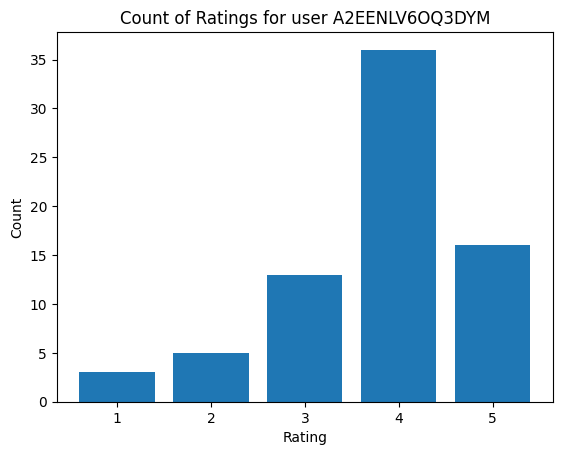

In [251]:
plot_ratings_for_user(selected_user_id, ratings_by_reviewer)

## Deciding how we will test



In [252]:
# Portion we want to leave to test our models
test_portion = 0.1

RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA = {}
regrets_for_ISOMAP_fixed_beta = []
labels_for_ISOMAP_fixed_beta = []
RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA = {}
regrets_for_ISOMAP_increasing_beta = []
labels_for_ISOMAP_increasing_beta = []

RESULTS_BY_DIMENSION_PCA_FIXED_BETA = {}
regrets_for_PCA_fixed_beta = []
labels_for_PCA_fixed_beta = []
RESULTS_BY_DIMENSION_PCA_INCREASING_BETA = {}
regrets_for_PCA_increasing_beta = []
labels_for_PCA_increasing_beta = []

In [253]:
# Separating training and test data
ratings_by_reviewer_training, ratings_by_reviewer_test = separate_training_test_data(ratings_by_reviewer, test_portion)

### Linear UCB for ISOMAP with fixed beta

In [254]:
n_simulations = 30
n_rounds = 500
max_reward = 5
noise = 0.0
lambda_param = 0.1

# Running the algorithm for a given user
RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA = train_linear_ucb_for_one_user_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=2.0)

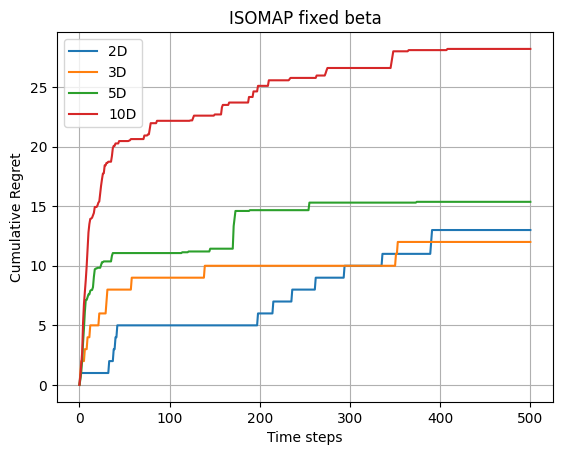

In [255]:
# Plotting of a given user
regrets_for_ISOMAP_fixed_beta = [t[0] for t in RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA.values()] 
labels_for_ISOMAP_fixed_beta = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]
plot_multiple(regrets_for_ISOMAP_fixed_beta, labels_for_ISOMAP_fixed_beta, 'ISOMAP fixed beta', "Time steps", "Cumulative Regret")

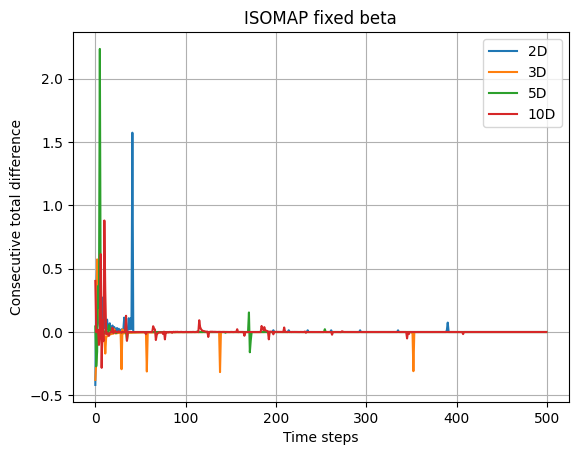

In [256]:
diffs_for_ISOMAP = []
labels_for_ISOMAP = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]

for key in ISOMAP_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_ISO_MAP_FIXED_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    diffs_for_ISOMAP.append(diff)

plot_multiple(diffs_for_ISOMAP, labels_for_ISOMAP, 'ISOMAP fixed beta', "Time steps", "Consecutive total difference")

On the graph above, you can see the consecutive difference (sum of absolute differences every element in the estimated feature vector between each consecutive time step)

At the end of a run, we have the average theta hat at the end of the simulations for a particular user, with this, we can calculate its dot product with the arm it chooses next and we can find the absolute difference between the estimated reward and the true reward.

### Linear UCB for ISOMAP with logarithmic increasing beta

In [257]:
RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA = train_linear_ucb_for_one_user_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=False, beta_value=8.0)


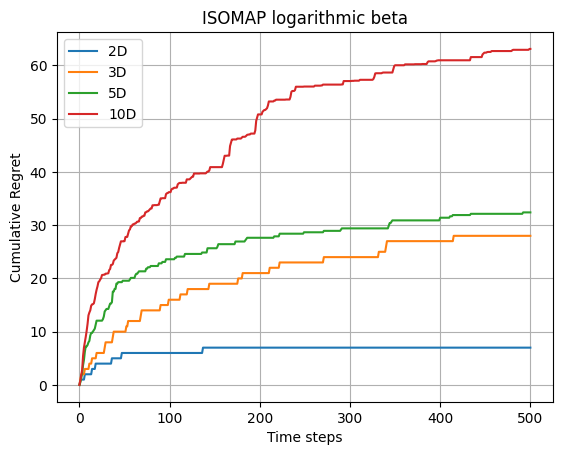

In [258]:
regrets_for_ISOMAP_increasing_beta = [t[0] for t in RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA.values()] 
labels_for_ISOMAP_increasing_beta = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]
 
plot_multiple(regrets_for_ISOMAP_increasing_beta, labels_for_ISOMAP_increasing_beta, 'ISOMAP logarithmic beta', "Time steps", "Cumulative Regret")

In [259]:
diffs_for_ISOMAP = []
labels_for_ISOMAP = [str(key) + 'D' for key in ISOMAP_PATHS_BY_DIMENSION.keys()]

for key in ISOMAP_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_ISO_MAP_INCREASING_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    
    diffs_for_ISOMAP.append(diff)

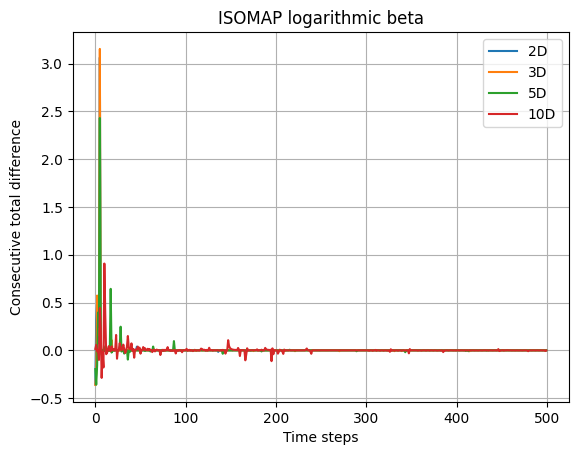

In [260]:

plot_multiple(diffs_for_ISOMAP, labels_for_ISOMAP, 'ISOMAP logarithmic beta', "Time steps", "Consecutive total difference")

### Linear UCB for PCA with fixed beta

In [261]:
RESULTS_BY_DIMENSION_PCA_FIXED_BETA = train_linear_ucb_for_one_user_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=True, beta_value=2.0)


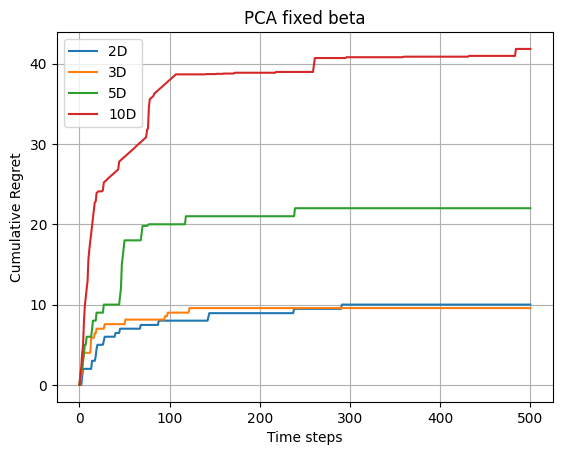

In [262]:
regrets_for_PCA_FIXED_BETA = [t[0] for t in RESULTS_BY_DIMENSION_PCA_FIXED_BETA.values()] 
labels_for_PCA_FIXED_BETA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]
 
plot_multiple(regrets_for_PCA_FIXED_BETA, labels_for_PCA_FIXED_BETA, 'PCA fixed beta', "Time steps", "Cumulative Regret")

In [263]:
diffs_for_PCA = []
labels_for_PCA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]

for key in PCA_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_PCA_FIXED_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    
    diffs_for_PCA.append(diff)

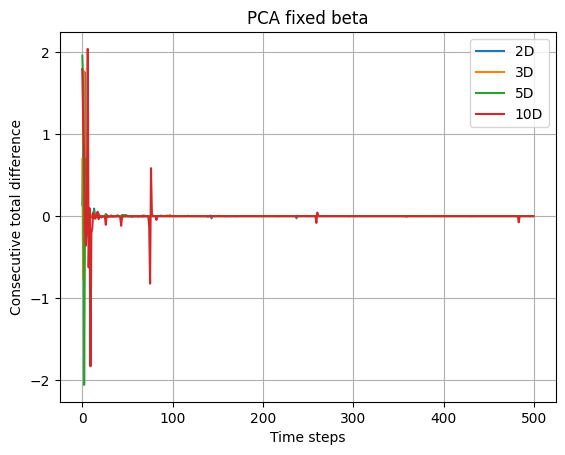

In [264]:

plot_multiple(diffs_for_PCA, labels_for_PCA, 'PCA fixed beta', "Time steps", "Consecutive total difference")

### Linear UCB for PCA with logarithmic increasing beta

In [265]:
RESULTS_BY_DIMENSION_PCA_INCREASING_BETA = train_linear_ucb_for_one_user_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, selected_user_id, n_simulations, n_rounds, max_reward, noise, lambda_param, beta_fixed=False, beta_value=4.0)


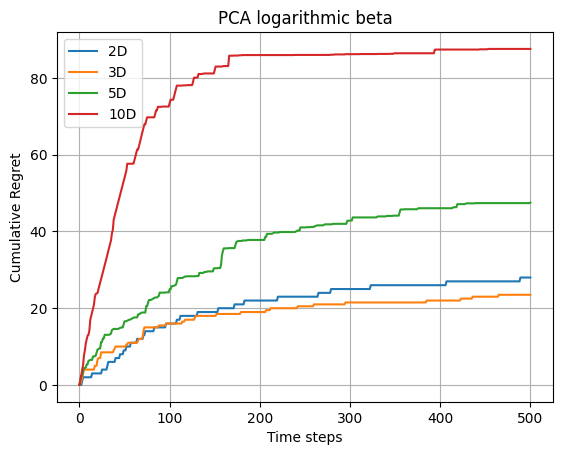

In [266]:
regrets_for_PCA_INCREASING_BETA = [t[0] for t in RESULTS_BY_DIMENSION_PCA_INCREASING_BETA.values()] 
labels_for_PCA_INCREASING_BETA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]
 
plot_multiple(regrets_for_PCA_INCREASING_BETA, labels_for_PCA_INCREASING_BETA, 'PCA logarithmic beta', "Time steps", "Cumulative Regret")

In [267]:
diffs_for_PCA = []
labels_for_PCA = [str(key) + 'D' for key in PCA_PATHS_BY_DIMENSION.keys()]

for key in PCA_BY_DIMENSION:
    avg_curr_all_theta_hat = RESULTS_BY_DIMENSION_PCA_INCREASING_BETA[key][1]
    # Make the array collapse and sum
    sum_array = np.sum(avg_curr_all_theta_hat, axis=0)
    # Compute the differences between consecutive elements
    diff = np.diff(sum_array)
    
    diffs_for_PCA.append(diff)

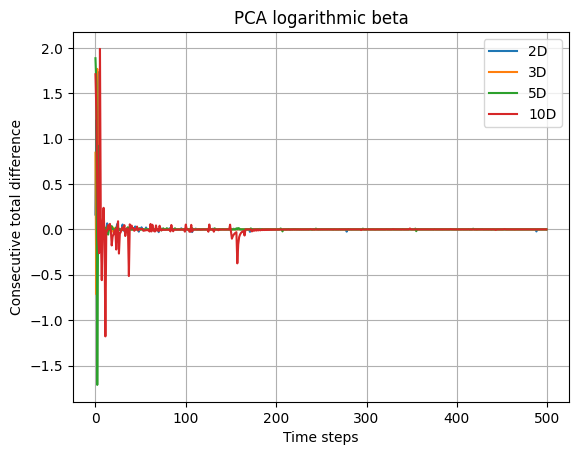

In [268]:

plot_multiple(diffs_for_PCA, labels_for_PCA, 'PCA logarithmic beta', "Time steps", "Consecutive total difference")

# Simulating on all users and testing linear ucb

## Preparing the inputs

In [280]:
test_portion = 0.1
# Separating training and test data
ratings_by_reviewer_training, ratings_by_reviewer_test = separate_training_test_data(ratings_by_reviewer, test_portion)

In [320]:
n_simulations = 6
n_rounds = 500
max_reward = 5
noise = 0.0
lambda_param = 0.1

## Finding out the optimal beta

In order to do that, we will only look at the graph of average differences for multiple values of beta (fixed). Then we will proceed to do the same for an logarithmically increasing beta.

In [282]:
beta_values = [2.0, 5.0, 8.0, 10.0, 15.0]

### ISOMAP with fixed beta

In [291]:
# avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)
# np.save('isomap_fixed_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

avg_regrets_by_dim, avg_diff_by_dim = np.load('isomap_fixed_beta_diffs.npy', allow_pickle=True)

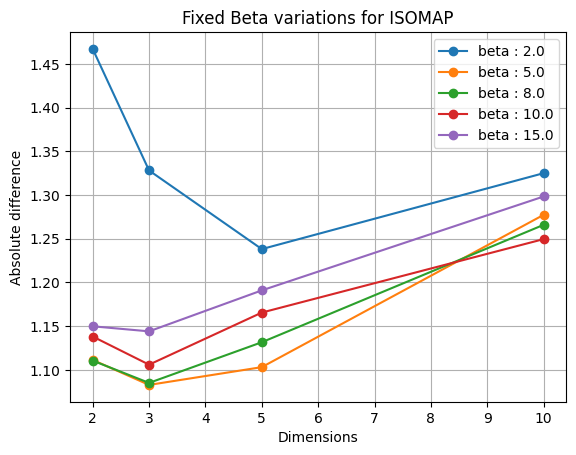

In [292]:
# Plot

list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Fixed Beta variations for ISOMAP", list_of_labels)



### ISOMAP with increasing beta

In [293]:
# avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)
# np.save('isomap_increasing_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

avg_regrets_by_dim, avg_diff_by_dim = np.load('isomap_increasing_beta_diffs.npy', allow_pickle=True)


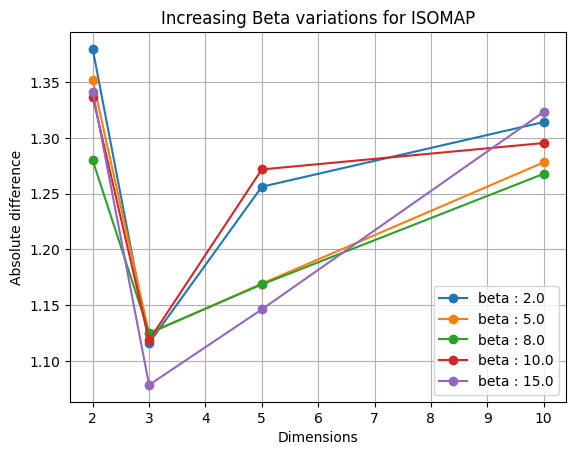

In [294]:
# Plot
list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Increasing Beta variations for ISOMAP", list_of_labels)


### PCA with fixed beta

In [295]:
# avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)
# np.save('pca_fixed_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

avg_regrets_by_dim, avg_diff_by_dim = np.load('pca_fixed_beta_diffs.npy', allow_pickle=True)

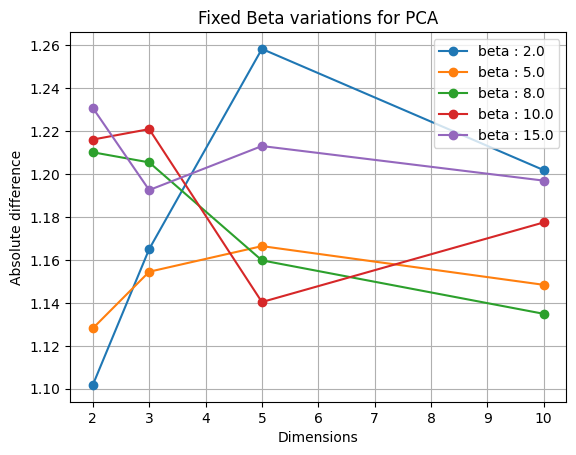

In [296]:
# Plot
list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Fixed Beta variations for PCA", list_of_labels)


### PCA with increasing beta

In [297]:
# avg_regrets_by_dim, avg_diff_by_dim = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)
# np.save('pca_increasing_beta_diffs.npy', (avg_regrets_by_dim, avg_diff_by_dim))

avg_regrets_by_dim, avg_diff_by_dim = np.load('pca_increasing_beta_diffs.npy', allow_pickle=True)


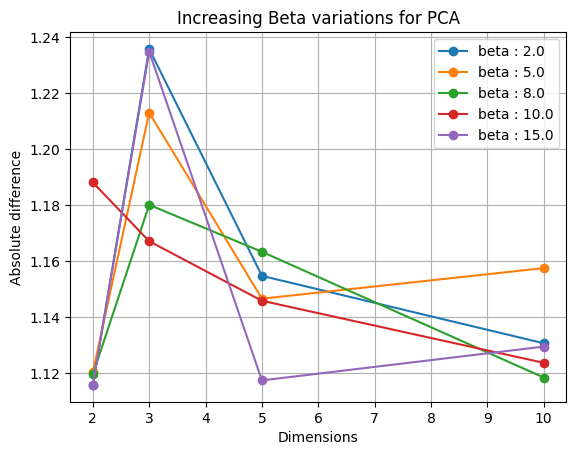

In [298]:
# Plot
list_of_dict = avg_diff_by_dim
list_of_labels = list_of_labels_from_values_list(beta_values, "beta : ")
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Increasing Beta variations for PCA", list_of_labels)


## Discussion of results :

We discover that the best value of beta depends ...

## Plotting the average differences for ISOMAP and PCA with both fixed beta and increasing beta 
We are running this experiment with a good beta found from the previous part

In [328]:
beta_values = [8.0]
n_simulations = 6


In [329]:
avg_regrets_by_dim_isomap_fixed_beta, avg_diff_by_dim_isomap_fixed_beta = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)

In [330]:
avg_regrets_by_dim_isomap_increasing_beta, avg_diff_by_dim_isomap_increasing_beta = simulation_on_all_users_all_dimensions(ISOMAP_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)

In [331]:
avg_regrets_by_dim_pca_fixed_beta, avg_diff_by_dim_pca_fixed_beta = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, True, beta_values)

In [332]:
avg_regrets_by_dim_pca_increasing_beta, avg_diff_by_dim_pca_increasing_beta = simulation_on_all_users_all_dimensions(PCA_BY_DIMENSION, ratings_by_reviewer_training, ratings_by_reviewer_test, n_simulations, n_rounds, max_reward, noise, lambda_param, False, beta_values)

In [333]:
# Preparing to plot everything
list_of_dict = []
list_of_labels = [] 

list_of_dict.append(avg_diff_by_dim_isomap_fixed_beta[0])
list_of_labels.append("ISOMAP fixed beta")

list_of_dict.append(avg_diff_by_dim_isomap_increasing_beta[0])
list_of_labels.append("ISOMAP increasing beta")

list_of_dict.append(avg_diff_by_dim_pca_fixed_beta[0])
list_of_labels.append("PCA fixed beta")

list_of_dict.append(avg_diff_by_dim_pca_increasing_beta[0])
list_of_labels.append("PCA increasing beta")


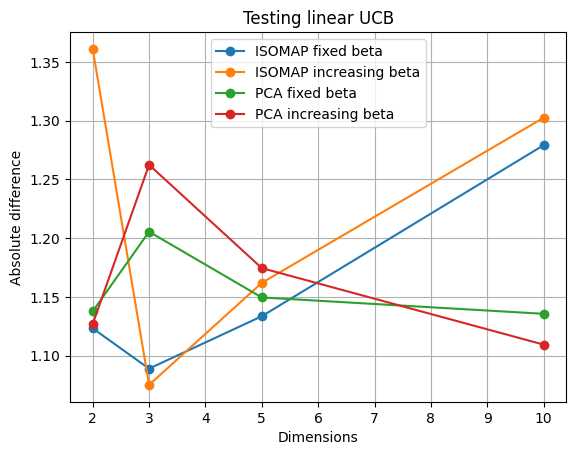

In [334]:
plot_dict_list(list_of_dict, "Dimensions", "Absolute difference", "Testing linear UCB", list_of_labels)